In [1]:
import numpy as np
from models import DLDSwithControl, DeepDLDS, SimpleNN
from datasets import CdLDSDataGenerator
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import plotly.express as px

In [2]:
generator = DLDSwithControl(CdLDSDataGenerator(K=1, D_control=0, fix_point_change=False, eigenvalue_radius=0.995))

# generate toy data
X = generator.datasets.generate_data(1000, sigma=0.01)

# z-score normalization
# X = (X - X.mean(axis=0)) / X.std(axis=0)

X1 = torch.tensor(X[:, :-1], dtype=torch.float32)
X2 = torch.tensor(X[:, 1:], dtype=torch.float32)

In [3]:
generator = DLDSwithControl(CdLDSDataGenerator(K=1, D_control=0, fix_point_change=False, eigenvalue_radius=0.995))

# generate toy data
X = generator.datasets.generate_data(1000, sigma=0.01)

# z-score normalization
# X = (X - X.mean(axis=0)) / X.std(axis=0)

X1 = torch.tensor(X[:, :-1], dtype=torch.float32)
X2 = torch.tensor(X[:, 1:], dtype=torch.float32)

In [4]:
np.save('data.npy', X)

In [5]:
input_size = X1.shape[0]
num_subdyn = 3
output_size = X2.shape[0]
simple_model = DeepDLDS(input_size, output_size, num_subdyn, X1.shape[1])
model = torch.load('models/model.pth', weights_only=False)
simple_model.load_state_dict(model)

<All keys matched successfully>

In [6]:
# predict the next time step
X2_hat = []
with torch.no_grad():
    for i in range(X1.shape[1]):
        y = simple_model(X1[:,i], i)
        X2_hat.append(y)

In [7]:
# predict all time steps from initial state

X2_hat_all = []
X2_hat_all.append(X1[:,0])
with torch.no_grad():
    for i in range(X1.shape[1]):
        y = simple_model(X2_hat_all[-1].squeeze(), i)
        X2_hat_all.append(y)

In [8]:
X2_hat_all

[tensor([-0.2916, -2.2143,  0.7326,  0.3559]),
 tensor([[-0.3071, -2.8961,  1.1621,  0.4988]]),
 tensor([[-0.3286, -3.8035,  1.7982,  0.6813]]),
 tensor([[-0.3608, -5.0154,  2.7361,  0.9114]]),
 tensor([[-0.4107, -6.6369,  4.1123,  1.1968]]),
 tensor([[-0.4895, -8.8152,  6.1275,  1.5454]]),
 tensor([[ -0.6138, -11.7478,   9.0705,   1.9621]]),
 tensor([[ -0.8091, -15.7076,  13.3596,   2.4472]]),
 tensor([[ -1.1130, -21.0686,  19.5988,   2.9910]]),
 tensor([[ -1.5817, -28.3496,  28.6645,   3.5673]]),
 tensor([[ -2.2981, -38.2644,  41.8212,   4.1215]]),
 tensor([[ -3.3862, -51.8261,  60.9278,   4.5551]]),
 tensor([[ -5.0246, -70.3917,  88.6078,   4.6911]]),
 tensor([[ -7.4811, -95.9402, 128.7600,   4.2427]]),
 tensor([[ -11.1420, -131.1466,  186.9439,    2.7384]]),
 tensor([[ -16.5691, -179.7524,  271.1255,   -0.5659]]),
 tensor([[ -24.5822, -247.0220,  392.8732,   -6.8299]]),
 tensor([[ -36.3782, -340.4098,  568.9577,  -17.8385]]),
 tensor([[ -53.6872, -470.3158,  823.4715,  -36.3162]]),

In [9]:
px.line(torch.stack(X2_hat_all[1:]).squeeze())

In [10]:
px.line(X2.T)

In [11]:
px.line(torch.stack(X2_hat).squeeze())

In [12]:
coefficients = np.array([c.detach().numpy() for c in simple_model.soft_coeffs])

px.line(coefficients.T)

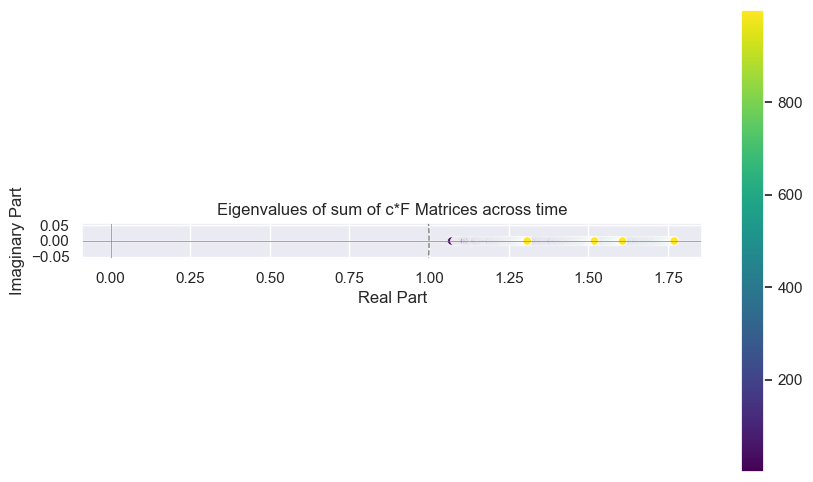

In [13]:
#%%script true
import numpy.linalg as linalg
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme()


plt.figure(figsize=(10, 6))

colors = {'1': 'red', '2': 'blue', '3': 'green', '4': 'purple'}  

data = []

for t in range(X2.shape[1]):
    f_sum = np.sum([simple_model.coeffs[idx].detach().numpy()[t]*f_i.effective_W().detach().numpy() for idx, f_i in enumerate(simple_model.F)], axis=0)
    eigenvalue = linalg.eig(f_sum)[0]
    df = pd.DataFrame({'real': np.real(eigenvalue), 'imag': np.imag(eigenvalue)})
    data.append(df)
              
df = pd.concat(data, keys=[str(i+1) for i in range(X2.shape[1])])

ax = sns.scatterplot(data=df, x='real', y='imag', alpha=1, hue=df.index.get_level_values(0), palette='viridis', marker='o', legend=False)

# Add a colorbar
norm = plt.Normalize(1, 999)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # Needed to trick colorbar into working with ScalarMappable

cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap='viridis', norm=norm),
    ax=plt.gca()
)

plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues of sum of c*F Matrices across time')

# Add a unit circle
unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(unit_circle)

# Set equal scaling to ensure the unit circle is round
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()


In [14]:
linalg.eig(simple_model.F[0].effective_W().detach().numpy())[0]

array([0.3783068 , 0.48158532, 0.5451273 , 0.6191585 ], dtype=float32)

In [15]:
#simple_model.F[0].weight.detach().numpy()#.sum(axis=1)